In [41]:
import matplotlib.pyplot as plt
from dfmdash.results import parse_run_results
from dfmdash.dfm import ModelRunner
from pathlib import Path

from datetime import datetime
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

plt.style.use("ggplot")

# Data

Read in Factors

In [42]:
all_factors = pd.read_csv('./results/factors.csv')
all_factors.head()

,Time,Factor_Pandemic,Factor_Consumption,Factor_GDP,Factor_Cons3,Factor_Cons4,Factor_Cons5,Factor_Cons2,Factor_Cases5,Factor_Cases2,...,Factor_Deaths2,Factor_Cases3,Factor_Deaths3,Factor_Cases4,Factor_Cases1,Factor_Hosp2,Factor_Hosp1,Factor_Deaths4,Factor_Deaths1,State
0,2/1/2012,-1.161055,0.170095,294888.4089,22717.46446,43092.70514,135937.3315,65810.18635,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
1,3/1/2012,-1.171222,-0.025467,295976.4376,22726.87622,43088.33409,136033.2130,65815.23537,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
2,4/1/2012,-1.171824,-0.416690,296195.7022,22749.68458,43109.43331,136209.1536,65859.15126,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
3,5/1/2012,-1.171860,-2.142386,297136.4557,22827.90665,43235.54277,136716.8652,66063.49119,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
4,6/1/2012,-1.171862,-1.655460,297893.9661,22892.06050,43334.97152,137140.3855,66227.08216,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN


In [43]:
def normalize(df, batch_col=None):
    time = df.index
    if batch_col:
        batch_column = df[batch_col].copy()
        df = df.drop(columns=[batch_col])
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=time)
        df[batch_col] = batch_column
    else:
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=time)
    return df

Read in normalized data

In [44]:
dfs = []
for subdir in Path('./results').iterdir():
    if subdir.is_dir():
        raw = pd.read_csv(subdir / 'df.csv')
        raw['State'] = subdir.name
        dfs.append(raw)

norm = pd.concat(dfs)
norm.head()

,Time,GDP,Cons3,Cons4,Cons5,Cons2,Cases5,Cases2,Deaths5,Deaths2,Cases3,Deaths3,Cases4,Cases1,Hosp2,Hosp1,Deaths4,Deaths1,State
0,2/1/2012,0.653034,0.343526,0.285676,0.599939,0.237297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
1,3/1/2012,0.658531,0.364740,0.309120,0.616711,0.266172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
2,4/1/2012,0.603592,0.403734,0.352081,0.647603,0.319136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
3,5/1/2012,0.648975,0.564603,0.528832,0.775285,0.537231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
4,6/1/2012,0.637306,0.523144,0.483472,0.742286,0.481186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN


## Figure 1 - Pandemic

In [45]:
columns = [
    "Cases5",
    "Cases2",
    "Deaths5",
    "Deaths2",
    "Cases3",
    "Deaths3",
    "Cases4",
    "Cases1",
    "Hosp1",
    "Deaths4",
    "Deaths1",
]
factor = "Factor_Pandemic"
state = "MA"
time = datetime(2020, 1, 1)
invert = True
df = norm[norm.State == state].set_index("Time").drop(columns=["State"])[columns]
factors = all_factors[all_factors.State == state].set_index("Time")

if invert:
    factors[factor] = factors[factor] * -1

df = df.join(factors[[factor]]).rename(columns={factor: factor[7:]})
df.index = pd.DatetimeIndex(df.index)
df = df[df.index > time]
df = normalize(df)
df = df.melt(var_name="Metric", value_name="Normalized Value", ignore_index=False)
df['Label'] = ['Factor' if x == factor[7:] else 'Data' for x in df.Metric]
df = df.reset_index().sort_values(['Metric', 'Time'])
df.head()

,Time,Metric,Normalized Value,Label
245,2020-02-01,Cases1,0.000000,Data
246,2020-03-01,Cases1,0.033052,Data
247,2020-04-01,Cases1,0.138976,Data
248,2020-05-01,Cases1,0.072053,Data
249,2020-06-01,Cases1,0.016776,Data


### Theme 1

In [46]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 20,
        "legend.fontsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

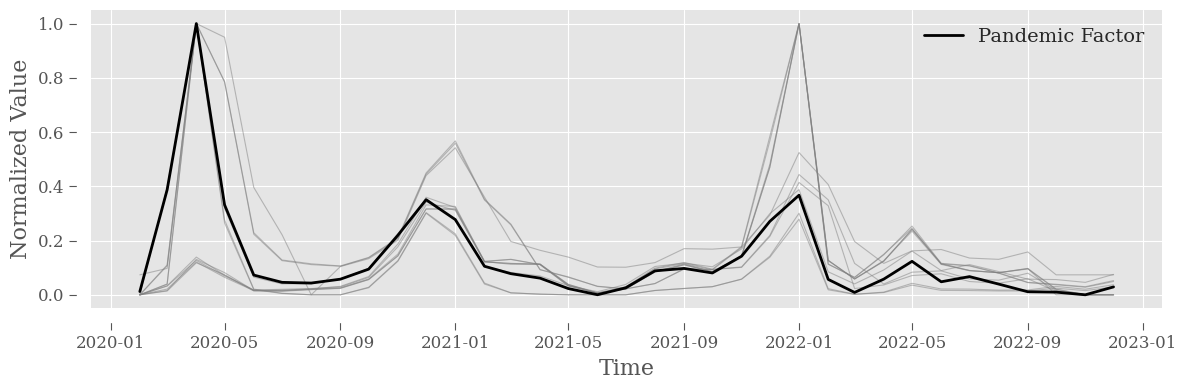

In [47]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Pandemic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

### Theme 2

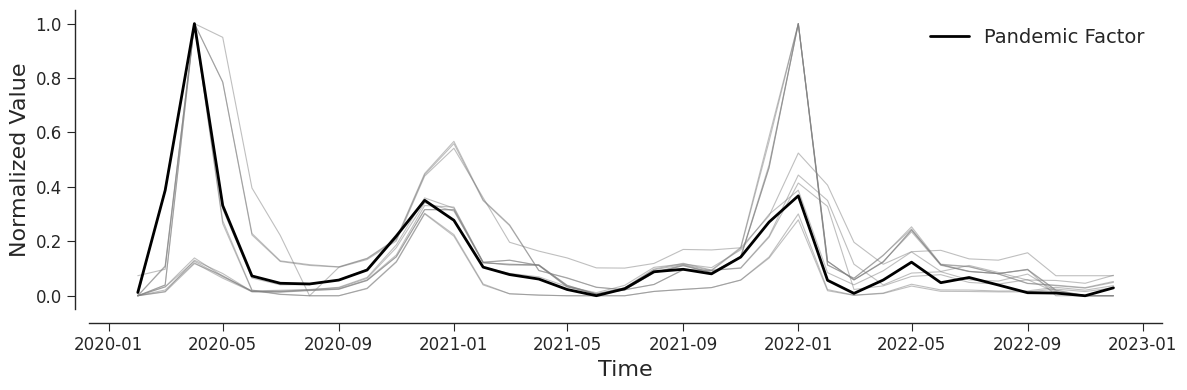

In [48]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Pandemic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

## Figure 2 - Consumption

In [49]:
columns = [
    "GDP",
    "Cons2",
    "Cons3",
    "Cons4",
    "Cons5",
]
factor = "Factor_Consumption"
state = "MA"
time = datetime(2020, 1, 1)
invert = True
df = norm[norm.State == state].set_index("Time").drop(columns=["State"])[columns]
factors = all_factors[all_factors.State == state].set_index("Time")

if invert:
    factors[factor] = factors[factor] * -1

df = df.join(factors[[factor]]).rename(columns={factor: factor[7:]})
df.index = pd.DatetimeIndex(df.index)
df = df[df.index > time]
df = normalize(df)
df = df.melt(var_name="Metric", value_name="Normalized Value", ignore_index=False)
df['Label'] = ['Factor' if x == factor[7:] else 'Data' for x in df.Metric]
df = df.reset_index().sort_values(['Metric', 'Time'])
df.head()

,Time,Metric,Normalized Value,Label
35,2020-02-01,Cons2,0.339886,Data
36,2020-03-01,Cons2,0.595546,Data
37,2020-04-01,Cons2,0.831451,Data
38,2020-05-01,Cons2,0.345702,Data
39,2020-06-01,Cons2,0.154480,Data


### Theme 1

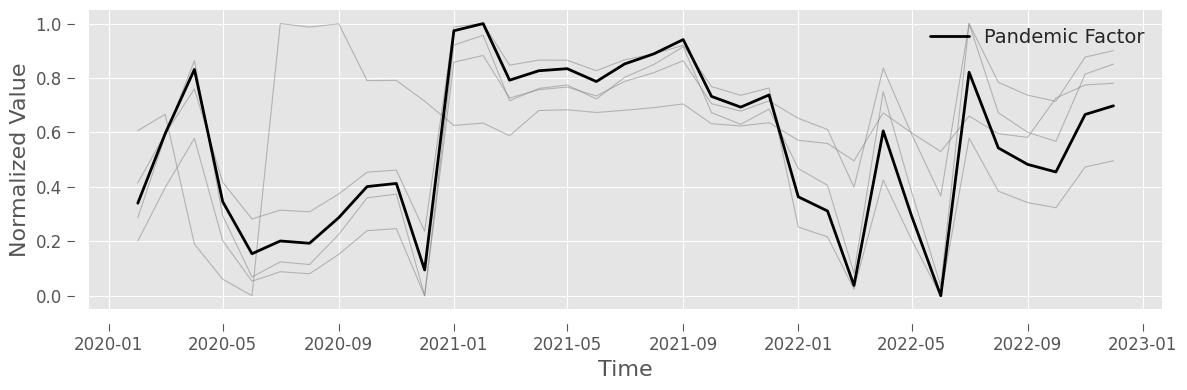

In [50]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Pandemic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

### Theme 2

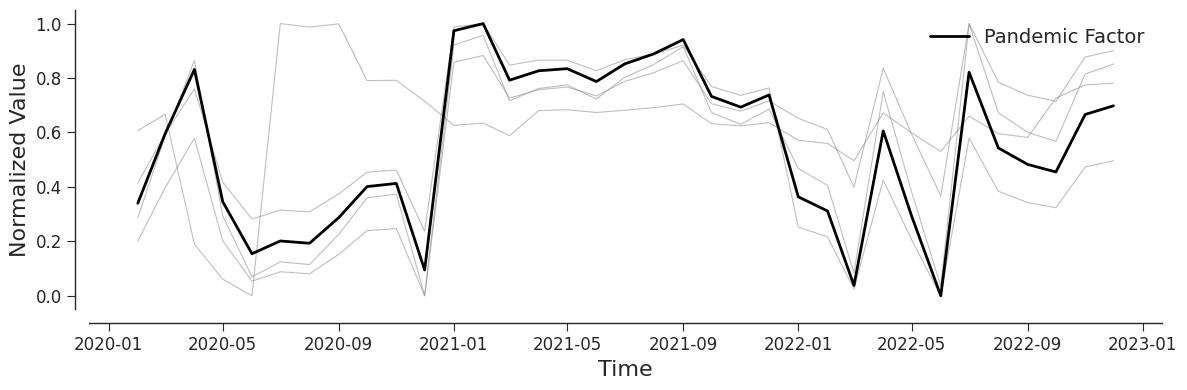

In [51]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Pandemic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()